In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

False


In [3]:
pd.set_option('display.max_columns', 80)

In [4]:
df = pd.read_csv('datos_clima_limpio_para_red_neuronal.csv')

In [5]:
# Obtenemos el rango en ese día de la temperatura máxima y mínima, el promedio de ambas y la desviación típica. Lo hacemos también para la humedad y la presión
df['rango_temperatura'] = df['tmax'] - df['tmin']
df['promedio_temperatura'] = (df['tmin'] + df['tmax']) / 2
df['desviacion_temperatura'] = df['tmed'] - df['promedio_temperatura']  # Desviación típica

df['temperatura_por_estacion'] = df['tmed'] * df['estacion']

df['temperatura_media_por_año'] = df.groupby(['municipio', 'año'])['tmed'].transform('mean')

df['rango_humedad'] = df['hrMax'] - df['hrMin']
df['promedio_humedad'] = (df['hrMax'] + df['hrMin']) / 2
df['desviacion_humedad'] = df['hrMedia'] - df['promedio_humedad']

df['rango_presion'] = df['presMax'] - df['presMin']
df['promedio_presion'] = (df['presMax'] + df['presMin']) / 2

# Si hay una temperatura media y una humedad media relativamente altas puede suponer que ha sido un día soleado, y por el contrario si son bajas puede suponer que ha hecho mal tiempo.
df['temp_humedad_medias'] = df['tmed'] * df['hrMedia']

# Dividimos el target en 24 horas para que encuentre una proporción de las horas respecto al día
df['proporcion_por_horas_sol'] = df['sol'] / 24

In [6]:
for col in ['horatmin', 'horatmax', 'horaHrMin', 'horaHrMax', 'horaracha', 'horaPresMax', 'horaPresMin']:
    df[col + '_año'] = pd.to_datetime(df[col]).dt.year
    df[col + '_mes'] = pd.to_datetime(df[col]).dt.month
    df[col + '_dia'] = pd.to_datetime(df[col]).dt.day
    df[col + '_hora'] = pd.to_datetime(df[col]).dt.hour
    df[col + '_minuto'] = pd.to_datetime(df[col]).dt.minute
    df[col + '_dia_semana'] = pd.to_datetime(df[col]).dt.weekday

In [7]:
df = df.drop(columns=['horatmin', 'horatmax', 'horaHrMin', 'horaHrMax', 'horaracha', 'horaPresMax', 'horaPresMin'])

In [8]:
df = df.drop(columns=['fecha'])

In [9]:
df = pd.get_dummies(df, columns=['provincia', 'municipio'], drop_first=True)
df = df.astype('float32')

In [10]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Supongamos que la columna de la variable objetivo es 'target'
X = df.drop(columns=['sol'])  # Características
y = df['sol']  # Etiqueta

X = np.array(X)
y = np.array(y)

# Primero divide en entrenamiento y test (80% entrenamiento, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Luego divide el conjunto temporal en validación y test (50% de la parte temporal para cada uno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Escalamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) # Escala la validación usando el ajuste del entrenamiento
X_test = scaler.transform(X_test) # Escala el test usando el ajuste del entrenamiento

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_val: {X_val.shape}")
print(f"Tamaño de X_test: {X_test.shape}")


Tamaño de X_train: (300099, 265)
Tamaño de X_val: (64307, 265)
Tamaño de X_test: (64308, 265)


In [11]:
# Convertir a tensores de PyTorch y moverlos a la GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)

        # Dropout (para regularización)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


input_dim = X_train.shape[1]
input_dim_tensor = torch.tensor(input_dim)

model = SimpleNN(input_dim)  # Mover el modelo a la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.00005)       # weight_decay=1e-5 para la regularización L2  \  de momento el que mejor funciona 0.00001, en 0.0001 ya produce saltos del gradiente.
loss_fn = nn.MSELoss()

In [16]:
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.cuda.empty_cache()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # Reduce la tasa de aprendizaje si la pérdida no mejora

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

y_pred_train = []
y_test_train = []

y_pred_val = []
y_test_val = []

y_pred_test = []
y_test_test = []

num_epochs = 15
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_r2 = 0

    for X_batch, y_batch in train_loader:  # Itera sobre los lotes del dataloader de entrenamiento
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        predictions = model(X_batch)
        loss = loss_fn(predictions.squeeze(), y_batch.squeeze())

        # Calcular R²
        predictions_cpu = predictions.squeeze().detach().cpu().numpy()
        y_batch_cpu = y_batch.squeeze().detach().cpu().numpy()
        r2 = r2_score(y_batch_cpu, predictions_cpu)

        loss.backward()
        optimizer.step()

        # Acumulamos la pérdida y el R²
        epoch_loss += loss.item()
        epoch_r2 += r2

        y_pred_train.extend(predictions_cpu)
        y_test_train.extend(y_batch_cpu)

    # Promedio de la pérdida y R² de la época
    avg_epoch_loss = epoch_loss / len(train_loader)  # Ya no es necesario usar X_train_tensor, lo calcula con len(train_loader)
    avg_epoch_r2 = epoch_r2 / len(train_loader)

    train_losses.append(avg_epoch_loss)
    train_r2_scores.append(avg_epoch_r2)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Train R2: {avg_epoch_r2:.4f}')

    # Ajuste de la tasa de aprendizaje
    scheduler.step(epoch_loss)

    # Evaluación en el conjunto de validación
    with torch.no_grad():
        model.eval()  # Establecer el modelo en modo de evaluación
        val_loss = 0
        val_r2 = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            val_predictions = model(X_val_batch)
            loss = loss_fn(val_predictions.squeeze(), y_val_batch.squeeze())

            val_loss += loss.item()

            # Calcular R²
            val_predictions_cpu = val_predictions.squeeze().detach().cpu().numpy()
            y_val_batch_cpu = y_val_batch.squeeze().detach().cpu().numpy()
            r2 = r2_score(y_val_batch_cpu, val_predictions_cpu)

            val_r2 += r2

            # Almacenamos las predicciones y las etiquetas reales de validación
            y_pred_val.extend(val_predictions_cpu)
            y_test_val.extend(y_val_batch_cpu)

        avg_val_loss = val_loss / len(val_loader)  # Promedio de la pérdida de validación
        avg_val_r2 = val_r2 / len(val_loader)  # Promedio de R² de validación

        val_losses.append(avg_val_loss)
        val_r2_scores.append(avg_val_r2)

        print(f'Validation Loss: {avg_val_loss:.4f}, Validation R2: {avg_val_r2:.4f}')

    # Evaluación en el conjunto de test
    with torch.no_grad():
        model.eval()  # Establecer el modelo en modo de evaluación
        test_loss = 0
        test_r2 = 0
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)

            test_predictions = model(X_test_batch)
            loss = loss_fn(test_predictions.squeeze(), y_test_batch.squeeze())

            test_loss += loss.item()

            # Calcular R²
            test_predictions_cpu = test_predictions.squeeze().detach().cpu().numpy()
            y_test_batch_cpu = y_test_batch.squeeze().detach().cpu().numpy()
            r2 = r2_score(y_test_batch_cpu, test_predictions_cpu)

            test_r2 += r2

            # Almacenamos las predicciones y las etiquetas reales de test
            y_pred_test.extend(test_predictions_cpu)
            y_test_test.extend(y_test_batch_cpu)

        avg_test_loss = test_loss / len(test_loader)  # Promedio de la pérdida de test
        avg_test_r2 = test_r2 / len(test_loader)  # Promedio de R² de test

        print(f'Test Loss: {avg_test_loss:.4f}, Test R2: {avg_test_r2:.4f}')

Epoch [1/15], Train Loss: 0.8987, Train R2: 0.9436
Validation Loss: 1.1030, Validation R2: 0.9312
Test Loss: 1.1007, Test R2: 0.9315
Epoch [2/15], Train Loss: 0.8602, Train R2: 0.9409
Validation Loss: 0.4505, Validation R2: 0.9720
Test Loss: 0.4498, Test R2: 0.9721
Epoch [3/15], Train Loss: 0.8432, Train R2: 0.9469
Validation Loss: 1.1111, Validation R2: 0.9308
Test Loss: 1.1087, Test R2: 0.9311
Epoch [4/15], Train Loss: 0.8161, Train R2: 0.9471
Validation Loss: 0.8847, Validation R2: 0.9449
Test Loss: 0.8833, Test R2: 0.9451
Epoch [5/15], Train Loss: 0.7704, Train R2: 0.9515
Validation Loss: 1.3774, Validation R2: 0.9140
Test Loss: 1.3771, Test R2: 0.9143
Epoch [6/15], Train Loss: 0.7616, Train R2: 0.9521
Validation Loss: 1.4782, Validation R2: 0.9079
Test Loss: 1.4757, Test R2: 0.9083
Epoch [7/15], Train Loss: 0.7591, Train R2: 0.9520
Validation Loss: 0.9451, Validation R2: 0.9411
Test Loss: 0.9437, Test R2: 0.9414
Epoch [8/15], Train Loss: 0.7181, Train R2: 0.9547
Validation Loss: 1

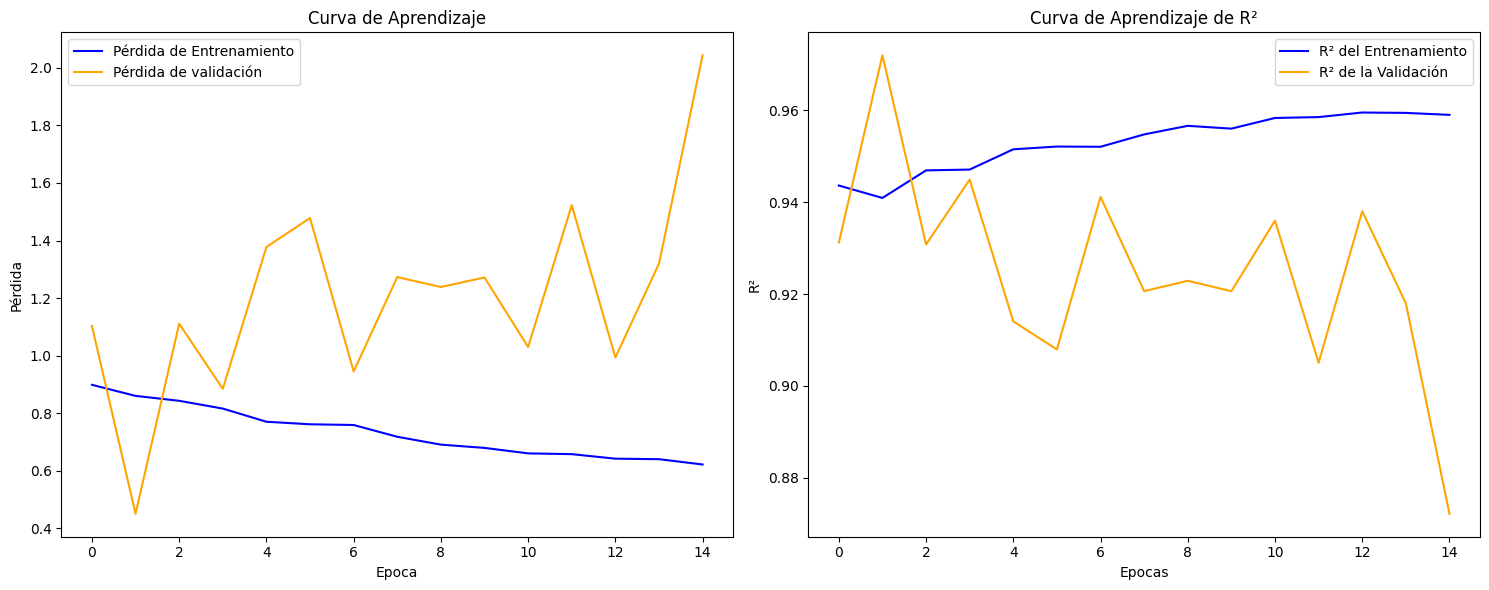

In [18]:
# Graficar Curvas de Aprendizaje: Pérdida y R²
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pérdida
ax1.plot(train_losses, label="Pérdida de Entrenamiento", color='blue')
ax1.plot(val_losses, label="Pérdida de validación", color='orange')
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Pérdida')
ax1.set_title('Curva de Aprendizaje')
ax1.legend()

# R²
ax2.plot(train_r2_scores, label="R² del Entrenamiento", color='blue')
ax2.plot(val_r2_scores, label="R² de la Validación", color='orange')
ax2.set_xlabel('Epocas')
ax2.set_ylabel('R²')
ax2.set_title('Curva de Aprendizaje de R²')
ax2.legend()

plt.tight_layout()
plt.show()


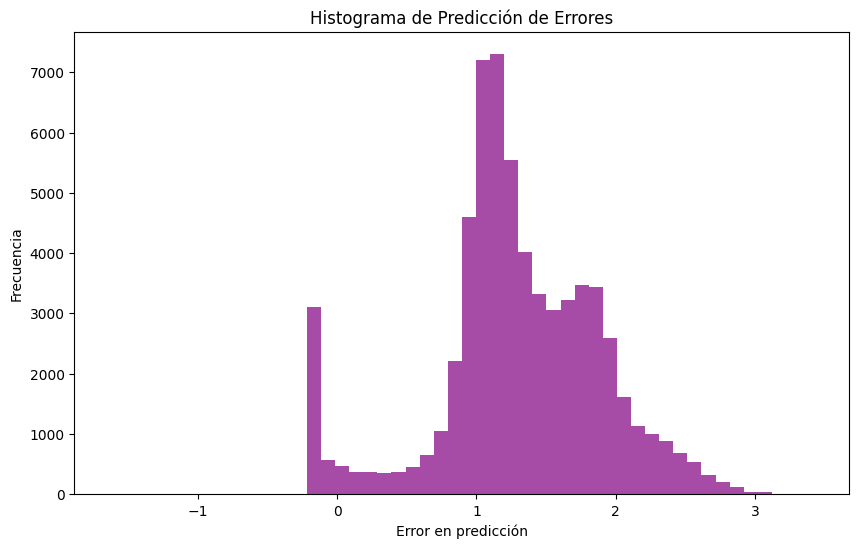

In [19]:
with torch.no_grad():
    model.eval()
    test_predictions = []
    test_labels = []
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        predictions = model(X_test_batch)
        test_predictions.append(predictions.squeeze().cpu().numpy())
        test_labels.append(y_test_batch.squeeze().cpu().numpy())

    test_predictions = np.concatenate(test_predictions)
    test_labels = np.concatenate(test_labels)

# Calcular los errores de predicción
errores = test_labels - test_predictions

# Graficar el histograma de los errores
plt.figure(figsize=(10, 6))
plt.hist(errores, bins=50, alpha=0.7, color='purple')
plt.xlabel('Error en predicción')
plt.ylabel('Frecuencia')
plt.title('Histograma de Predicción de Errores')
plt.show()

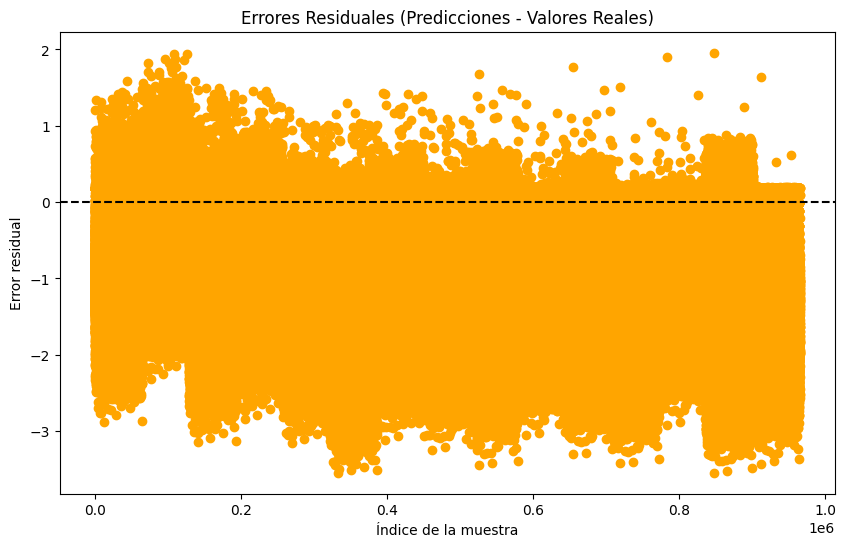

In [20]:
# Calcular los errores residuales
residuos = np.array(y_pred_test) - np.array(y_test_test)

# Visualizar los errores residuales
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuos)), residuos, color='orange')
plt.axhline(0, color='black', linestyle='--')  # Línea horizontal en 0
plt.title("Errores Residuales (Predicciones - Valores Reales)")
plt.xlabel("Índice de la muestra")
plt.ylabel("Error residual")
plt.show()


In [17]:
for i in range(100):
    print(f"Predicción de la fila {i}: Valor Predicción [{y_pred_test[i]}] -- Valor Real [{y_test_test[i]}]")

Predicción de la fila 0: Valor Predicción [4.763812065124512] -- Valor Real [6.099999904632568]
Predicción de la fila 1: Valor Predicción [10.518355369567871] -- Valor Real [11.5]
Predicción de la fila 2: Valor Predicción [0.918282687664032] -- Valor Real [1.7999999523162842]
Predicción de la fila 3: Valor Predicción [8.074786186218262] -- Valor Real [9.0]
Predicción de la fila 4: Valor Predicción [11.279412269592285] -- Valor Real [12.899999618530273]
Predicción de la fila 5: Valor Predicción [10.930477142333984] -- Valor Real [12.0]
Predicción de la fila 6: Valor Predicción [7.822504043579102] -- Valor Real [7.900000095367432]
Predicción de la fila 7: Valor Predicción [11.151287078857422] -- Valor Real [12.399999618530273]
Predicción de la fila 8: Valor Predicción [11.649415016174316] -- Valor Real [13.699999809265137]
Predicción de la fila 9: Valor Predicción [5.207215309143066] -- Valor Real [6.300000190734863]
Predicción de la fila 10: Valor Predicción [0.23246683180332184] -- Val

In [32]:
# Guardar el modelo entrenado (Sólo pesos)
# torch.save(model.state_dict(), 'modelo_entrenado_clima.pth')

In [33]:
# Para guardar el modelo entero (Pesos + Arquitectura)
# torch.save(model, 'modelo__entrenado_completo_clima.pth')